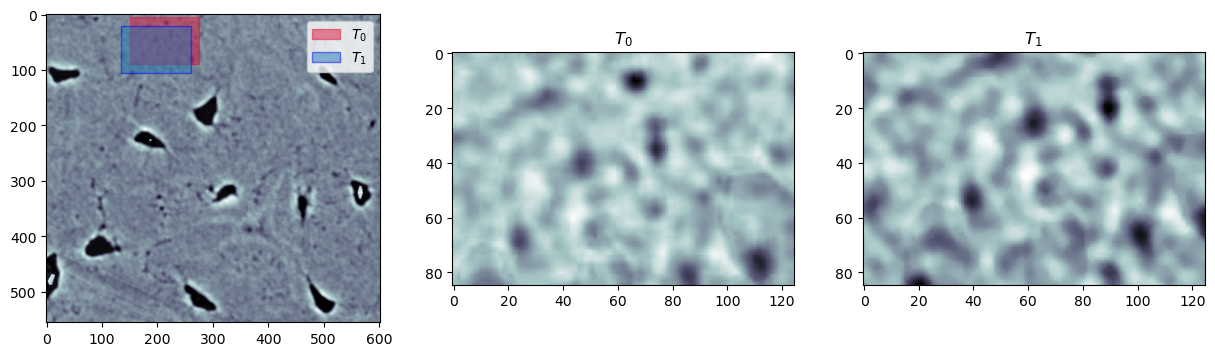

In [158]:
import numpy as np
from skimage.filters import median
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage.io import imread
from tqdm import tqdm
%matplotlib inline
full_img = imread("figures/bonegfiltslice.png")[:,:,0:3].mean(axis=2)
full_shift_img = median(
    np.roll(np.roll(full_img, -15, axis=0), 15, axis=1), footprint=np.ones((3, 3)))

def g_roi(x): return x[5:90, 150:275]

bw_img = g_roi(full_img)
shift_img = g_roi(full_shift_img)

fig, (ax0,ax1, ax2) = plt.subplots(1, 3, figsize=(15, 4))
ax0.imshow(full_img,cmap='bone')
r=Rectangle((150,5),125,85,ec='crimson',fc='crimson',alpha=0.5,label=r"$T_0$")
ax0.add_patch(r)
r=Rectangle((135,20),125,85,ec='blue',alpha=0.5,label=r"$T_1$")
ax0.add_patch(r)
ax0.legend()
ax1.imshow(bw_img, cmap='bone')
ax1.set_title('$T_0$')
ax2.imshow(shift_img, cmap='bone')
ax2.set_title('$T_1$');

# SimpleElastix

In [73]:
import SimpleITK as sitk
import numpy as np

# Convert the NumPy arrays to SimpleITK images
fixed_image_sitk = sitk.GetImageFromArray(bw_img)
moving_image_sitk = sitk.GetImageFromArray(shift_img)

# Initialize the SimpleElastix image registration object
# registration = sitk.ElastixImageFilter()
registration = sitk.SimpleElastix()


# Set the fixed and moving images
registration.SetFixedImage(fixed_image_sitk)
registration.SetMovingImage(moving_image_sitk)

# Set the parameter map for the registration
parameter_map = sitk.GetDefaultParameterMap('affine')
registration.SetParameterMap(parameter_map)

# Perform the image registration
registration.Execute()

# Get the registered image as a NumPy array
registered_image = sitk.GetArrayFromImage(registration.GetResultImage())


_, ax = plt.subplots(1,3,figsize=(15,4))

ax=ax.ravel()

for axs,img in zip(ax,[bw_img,shift_img,image1_warp]) :
    axs.imshow(img)

AttributeError: module 'SimpleITK' has no attribute 'SimpleElastix'

In [75]:
sitk.

Help on package SimpleITK:

NAME
    SimpleITK

DESCRIPTION
    # ========================================================================
    #
    #  Copyright NumFOCUS
    #
    #  Licensed under the Apache License, Version 2.0 (the "License");
    #  you may not use this file except in compliance with the License.
    #  You may obtain a copy of the License at
    #
    #         http://www.apache.org/licenses/LICENSE-2.0.txt
    #
    #  Unless required by applicable law or agreed to in writing, software
    #  distributed under the License is distributed on an "AS IS" BASIS,
    #  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
    #  See the License for the specific language governing permissions and
    #  limitations under the License.
    #
    # ========================================================================

PACKAGE CONTENTS
    SimpleITK
    _SimpleITK
    _version
    extra

DATA
    SITK_ITK_VERSION_MAJOR = 5
    SITK_ITK_VERSION_MINOR 

# SciKit Image

In [31]:
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle
from skimage.registration import optical_flow_ilk,optical_flow_tvl1
from skimage.transform import warp
reference_image, moving_image, disp = stereo_motorcycle()
# --- Convert the images to gray level: color is not supported.
reference_image = bw_img
moving_image    = shift_img 
[u,v]= optical_flow_tvl1(moving_image, reference_image)

In [32]:
flow.shape

(2, 85, 125)

In [33]:
nr, nc = bw_img.shape

row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                     indexing='ij')

image1_warp = warp(shift_img, np.array([row_coords + v, col_coords + u]),
                   mode='edge')

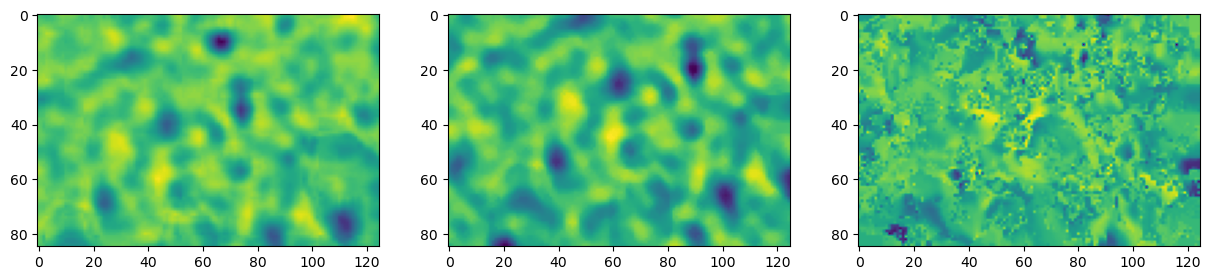

In [34]:
_, ax = plt.subplots(1,3,figsize=(15,4))

ax=ax.ravel()

for axs,img in zip(ax,[bw_img,shift_img,image1_warp]) :
    axs.imshow(img)

# Tensorflow version

In [179]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Generate a random image to use as the fixed image
fixed_image = np.random.rand(256, 256)

# Generate a random transformation to apply to the moving image
theta = np.pi/4
tx = 30
ty = -20
cos_t = np.cos(theta)
sin_t = np.sin(theta)
moving_image = np.zeros_like(fixed_image)
for i in range(fixed_image.shape[0]):
    for j in range(fixed_image.shape[1]):
        x = cos_t*(i-fixed_image.shape[0]/2) - sin_t*(j-fixed_image.shape[1]/2) + tx + fixed_image.shape[0]/2
        y = sin_t*(i-fixed_image.shape[0]/2) + cos_t*(j-fixed_image.shape[1]/2) + ty + fixed_image.shape[1]/2
        if x >= 0 and x < fixed_image.shape[0] and y >= 0 and y < fixed_image.shape[1]:
            moving_image[i, j] = fixed_image[int(np.floor(x)), int(np.floor(y))]

# Define the TensorFlow 2 graph
tf.compat.v1.disable_eager_execution()
graph = tf.Graph()
with graph.as_default():
    # Define the fixed and moving images as placeholders
    fixed_image_ph = tf.compat.v1.placeholder(tf.float32, shape=(None, None))
    moving_image_ph = tf.compat.v1.placeholder(tf.float32, shape=(None, None))

    # Define the transformation parameters as variables
    theta_var = tf.Variable(0.0, dtype=tf.float32)
    tx_var = tf.Variable(0.0, dtype=tf.float32)
    ty_var = tf.Variable(0.0, dtype=tf.float32)

    # Define the transformation matrix
    cos_t = tf.cos(theta_var)
    sin_t = tf.sin(theta_var)
    mat = tf.constant([[cos_t, -sin_t, tx_var], [sin_t, cos_t, ty_var], [0, 0, 1]])

    # Apply the transformation to the moving image
    transformed_image = tf.compat.v1.contrib.image.transform(moving_image_ph, mat, interpolation='BILINEAR')

    # Define the loss as the mean squared difference between the fixed and transformed moving images
    loss = tf.reduce_mean(tf.square(fixed_image_ph - transformed_image))

    # Define the optimizer
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.1).minimize(loss)

# Run the TensorFlow 2 graph to perform the image registration
with tf.compat.v1.Session(graph=graph) as sess:
    # Initialize the variables
    sess.run(tf.compat.v1.global_variables_initializer())

    # Perform the optimization
    for i in range(100):
        _, loss_val = sess.run([optimizer, loss], feed_dict={fixed_image_ph: fixed_image, moving_image_ph: moving_image})
        if i % 10 == 0:
            print('Iteration {}: Loss = {}'.format(i, loss_val))

    # Get the registered image
    registered_image = sess.run(transformed_image, feed_dict={moving_image_ph: moving_image,
                                                              theta_var: sess.run(theta_var),
                                                              tx_var: sess.run(tx_var),
                                                              ty_var: sess.run(ty_var)})

# Plot the results
plt.subplot(1, 3, 1)
plt.imshow(fixed_image, cmap='gray')
plt.title('Fixed image')
plt.axis('off')



TypeError: Expected any non-tensor type, but got a tensor instead.

# Tensorflow 2.0 style

In [181]:
# Load the fixed and moving images

import tensorflow as tf
from tensorflow.keras.preprocessing.image import apply_affine_transform

fixed_image  = tf.keras.preprocessing.image.load_img('figures/bonegfiltslice.png')
moving_image = tf.keras.preprocessing.image.load_img('figures/bonegfiltslice.png')
print(fixed_image)
# Convert the images to tensors
# fixed_image  = tf.keras.preprocessing.image.img_to_array(fixed_image)
# moving_image = tf.keras.preprocessing.image.img_to_array(moving_image)
# fixed_image  = tf.keras.preprocessing.image.img_to_array(bw_img)
# moving_image = tf.keras.preprocessing.image.img_to_array(shift_img)
fixed_image  = tf.convert_to_tensor(bw_img)
moving_image = tf.convert_to_tensor(shift_img)


# Normalize the images
fixed_image  = fixed_image  / 255.0
moving_image = moving_image / 255.0

<PIL.Image.Image image mode=RGB size=602x556 at 0x152222160>


In [147]:
# original GPT version
import tensorflow as tf

def affine_transform(fixed_img, moving_img, transform_params):
    # Define affine transform matrix
    cos_theta  = tf.math.cos(transform_params.numpy()[0])
    sin_theta  = tf.math.sin(transform_params[0])
    tx         = transform_params[1]
    ty         = transform_params[2]
    affine_mat = tf.reshape(tf.stack([cos_theta, -sin_theta, tx,
                                      sin_theta, cos_theta, ty]), (2, 3))

    # Apply affine transform to moving image
    batch_size = tf.shape(moving_img)[0]
    height     = tf.shape(moving_img)[1]
    width      = tf.shape(moving_img)[2]
    channels   = tf.shape(moving_img)[3]
    
    print(batch_size,height,width,channels)

    # Reshape image to 2D tensor and append ones for affine transform
    N = height * width * channels
    flat_img       = tf.reshape(moving_img, [batch_size,height * width * channels])
    ones           = tf.ones((batch_size, 1), dtype=tf.float32)
    
    homog_flat_img = tf.concat([flat_img, ones], axis=1)
    # Apply affine transform to homogenous coordinates
    homog_transformed = tf.matmul(homog_flat_img, tf.transpose(affine_mat))
    transformed       = tf.reshape(homog_transformed[:, :-1], [batch_size, height, width, channels])
    return transformed

def similarity_loss(fixed_img, moving_img, transform_params):
    # Apply affine transform to moving image
    transformed_img = affine_transform(fixed_img, moving_img, transform_params)
    # Compute mean squared error between fixed and transformed moving images
    mse = tf.reduce_mean(tf.square(fixed_img - transformed_img))
    return mse

In [76]:
@tf.function
def affine_transform(fixed_img, moving_img, transform_params):
    # Define affine transform matrix
    theta = transform_params[0]
    tx    = transform_params[1]
    ty    = transform_params[2]

    # Construct the affine transform matrix
    transform = tf.stack([
        tf.cos(theta), -tf.sin(theta), tx,
        tf.sin(theta), tf.cos(theta), ty
    ])
    transform = tf.reshape(transform, shape=(2, 3))

    # Apply the affine transform to the moving image
    

    return transformed

In [184]:
from skimage import transform as transf
import scipy.ndimage as nd

def affine_transform(fixed_img, moving_img, transform_params):
    # Define affine transform matrix
    theta = transform_params[0]
    tx    = transform_params[1]
    ty    = transform_params[2]
    
    mat=[cos_theta, -sin_theta, tx,
        sin_theta, cos_theta, ty]
    transformed_image = nd.affine_transform(moving_img, mat);
    
    return transformed_image

def affine_transform1(fixed_img, moving_img, transform_params):
    # Define affine transform matrix
    theta = transform_params[0]
    tx    = transform_params[1]
    ty    = transform_params[2]
    
    transformed=apply_affine_transform(moving_image,theta=theta,tx=tx,ty=ty)

    return transformed

def affine_transform_gpt(fixed_img, moving_img, transform_params):
    # Define affine transform matrix
    cos_theta  = tf.math.cos(transform_params[0])
    sin_theta  = tf.math.sin(transform_params[0])
    tx         = transform_params[1]
    ty         = transform_params[2]
    affine_mat = tf.reshape(tf.stack([cos_theta, -sin_theta, tx,
                                      sin_theta, cos_theta, ty]), (2, 3))

    # Apply affine transform to moving image
    height     = tf.shape(moving_img)[0]
    width      = tf.shape(moving_img)[1]
    
    channels   = 1
    
    print(height,width)

    # Reshape image to 2D tensor and append ones for affine transform
    N = height * width * channels
    flat_img       = tf.reshape(moving_img, [1,height * width * channels])
    ones           = tf.ones((1, 1), dtype=tf.float32)
    
    homog_flat_img = tf.concat([flat_img, ones], axis=1)
    # Apply affine transform to homogenous coordinates
    homog_transformed = tf.matmul(homog_flat_img, tf.transpose(affine_mat))
    transformed       = tf.reshape(homog_transformed[:, :-1], [1, height, width, channels])
    return transformed

from affine_op import affine_transform

def affine_transform2(fixed_img, moving_img, transform_params):
    cos_theta  = tf.math.cos(transform_params[0])
    sin_theta  = tf.math.sin(transform_params[0])
    tx         = transform_params[1]
    ty         = transform_params[2]
    affine_mat = tf.tile(tf.stack([cos_theta, -sin_theta, tx,
                                      sin_theta, cos_theta, ty]), (1,))
    
    affine_mat  = tf.reshape(affine_mat, (1, 6))
    transformed = affine_transform(moving_img, affine_mat)
    
    return transformed

def similarity_loss(fixed_img, moving_img, transform_params):
    # Apply affine transform to moving image
#     transformed_img = affine_transform1(fixed_img, moving_img, transform_params)
    transformed_img = moving_img
    
    # Compute mean squared error between fixed and transformed moving images
    mse = tf.reduce_mean(tf.square(fixed_img - transformed_img))
    
    return mse

# Define the transform parameters as trainable variables
theta = tf.Variable(0.0, dtype=tf.float32, trainable=True)
tx    = tf.Variable(0.0, dtype=tf.float32, trainable=True)
ty    = tf.Variable(0.0, dtype=tf.float32, trainable=True)
transform_params = [theta, tx, ty]

# Define the optimizer
optimizer = tf.optimizers.Adam()

# Define the training loop
for i in range(100):
    with tf.GradientTape() as tape:
        tape.watch(transform_params)
        tape.watch(moving_image)
        tape.watch(fixed_image)
        loss = similarity_loss(fixed_image, moving_image, transform_params)
        
    tf.print(transform_params)
    gradients = tape.gradient(loss, transform_params)

    print(gradients)
    optimizer.apply_gradients(zip(gradients, transform_params))
    
    if i % 100 == 0:
        print(f'Loss at step {i}: {loss.numpy()}')

# Apply the learned transform to the moving image
registered_image = affine_transform(fixed_image, moving_image, transform_params)

# Save the registered image
tf.keras.preprocessing.image.save_img('registered_image.jpg', registered_image[0])

[None, None, None]


ValueError: No gradients provided for any variable: (['Variable_6:0', 'Variable_7:0', 'Variable_8:0'],). Provided `grads_and_vars` is ((None, <tf.Variable 'Variable_6:0' shape=() dtype=float32>), (None, <tf.Variable 'Variable_7:0' shape=() dtype=float32>), (None, <tf.Variable 'Variable_8:0' shape=() dtype=float32>)).

In [183]:
loss = similarity_loss(fixed_image, moving_image, transform_params)

print(loss)

Tensor("Mean_2:0", shape=(), dtype=float64)


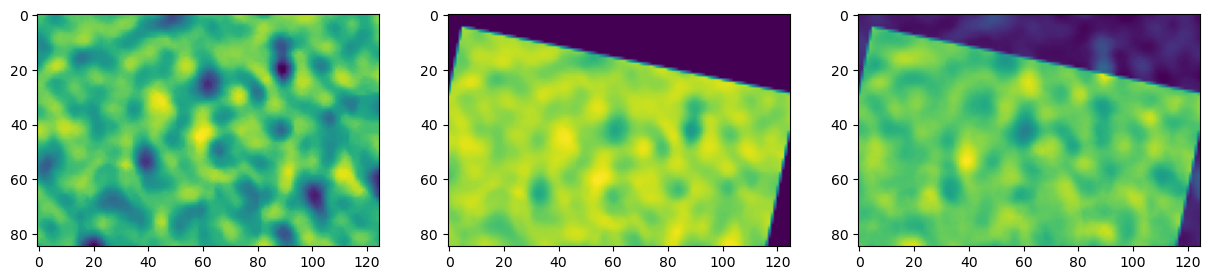

In [155]:
theta = tf.Variable(0.2, dtype=tf.float32)
tx    = tf.Variable(5.0, dtype=tf.float32)
ty    = tf.Variable(5.0, dtype=tf.float32)
transform_params = [theta, tx, ty]

registered_image = affine_transform(fixed_image, moving_image,transform_params)
_,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].imshow(moving_image)
ax[1].imshow(registered_image)
ax[2].imshow(registered_image-moving_image)

In [141]:
moving_image.shape

(85, 125, 1)